In [11]:
suppressPackageStartupMessages({
    #library(stringr)
    library(ggplot2)
    #library(RColorBrewer)
    library(reshape2)
    library(tibble)
    library(dplyr)
    #library(ggpubr)
})

theme_set(theme_minimal())
theme_update(text = element_text(size = 17))

In [2]:
anno_pep = read.table("../data/PhageScan_PeptideAnno.tsv", header = TRUE, sep = "\t", row.names = 1, stringsAsFactors=FALSE)
lhfc = read.table("../data/PhageScan_peptide_logHFC.csv", sep = ",")

In [3]:
peps = anno_pep[anno_pep$containsResSite==FALSE ,c("tile_id","pro_id","taxon_id","sublibrary")]
lhfc[rownames(peps),] %>% rowSums()>0 ->> peptide_fair_groundtruth
peps = cbind(peps,reactive = as.numeric(peptide_fair_groundtruth))
peps = droplevels(peps)

## Question

Do we get a good recall per base probed?

In [4]:
merge(aggregate(tile_id ~ sublibrary + reactive, data = peps, FUN = length), 
      aggregate(tile_id ~ sublibrary, data = peps, FUN = length), 
      by = "sublibrary", all = TRUE) %>% 
rename(total_peptides = tile_id.y) %>% rename(react_peptides = tile_id.x) %>% 
mutate(ratio = react_peptides/total_peptides) -> evaldf

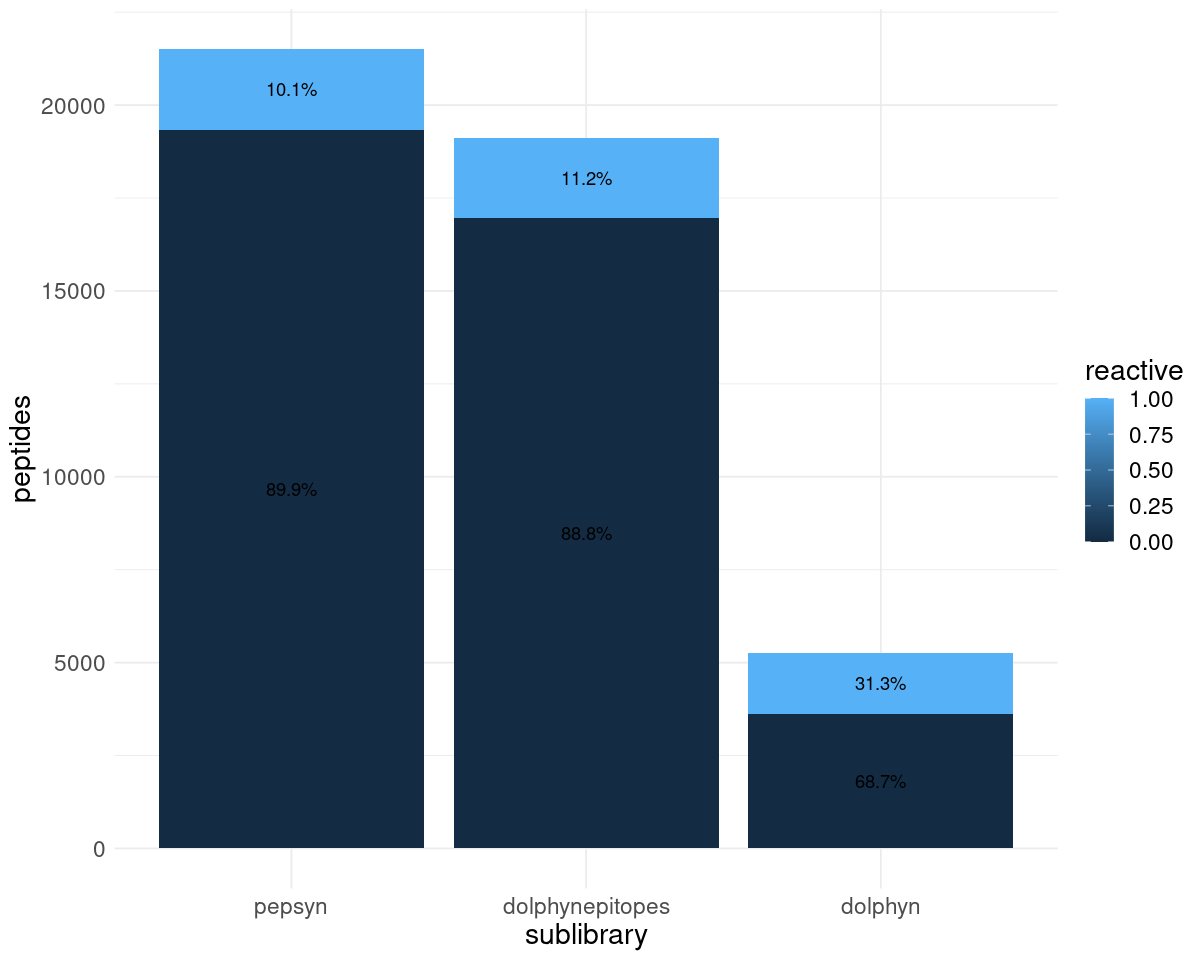

In [6]:
options(repr.plot.width=10, repr.plot.height=8)

evaldf %>% select(-total_peptides) %>% rename(peptides = react_peptides) %>%
mutate(sublibrary = factor(sublibrary, levels = c("pepsyn", "dolphynepitopes", "dolphyn"))) %>%
ggplot(aes(fill=reactive, y=peptides, x=sublibrary)) + 
    geom_bar(position=position_stack(reverse = FALSE), stat="identity") +    
    geom_text(aes(label=paste0(sprintf("%1.1f", 100 * ratio),"%")), position=position_stack(vjust=0.5)) 

## Question

Whats the recall/discovery power per protein/phage?

In [7]:
options(repr.plot.width=10, repr.plot.height=8)

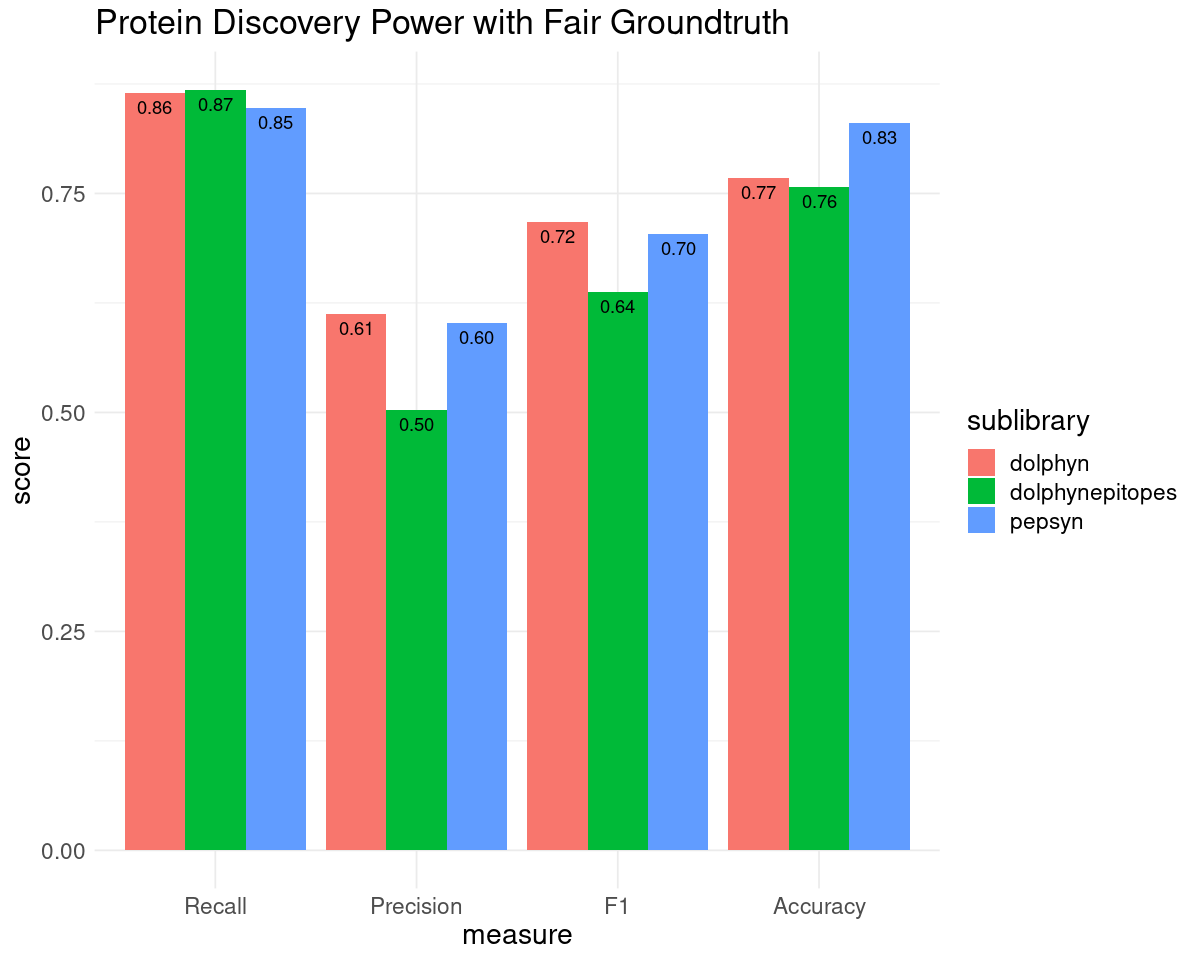

In [8]:
peps %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 2)) %>% select(-reactive) ->> protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(protein_truth, by = "pro_id") -> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) -> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) -> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") -> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) -> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power with Fair Groundtruth")

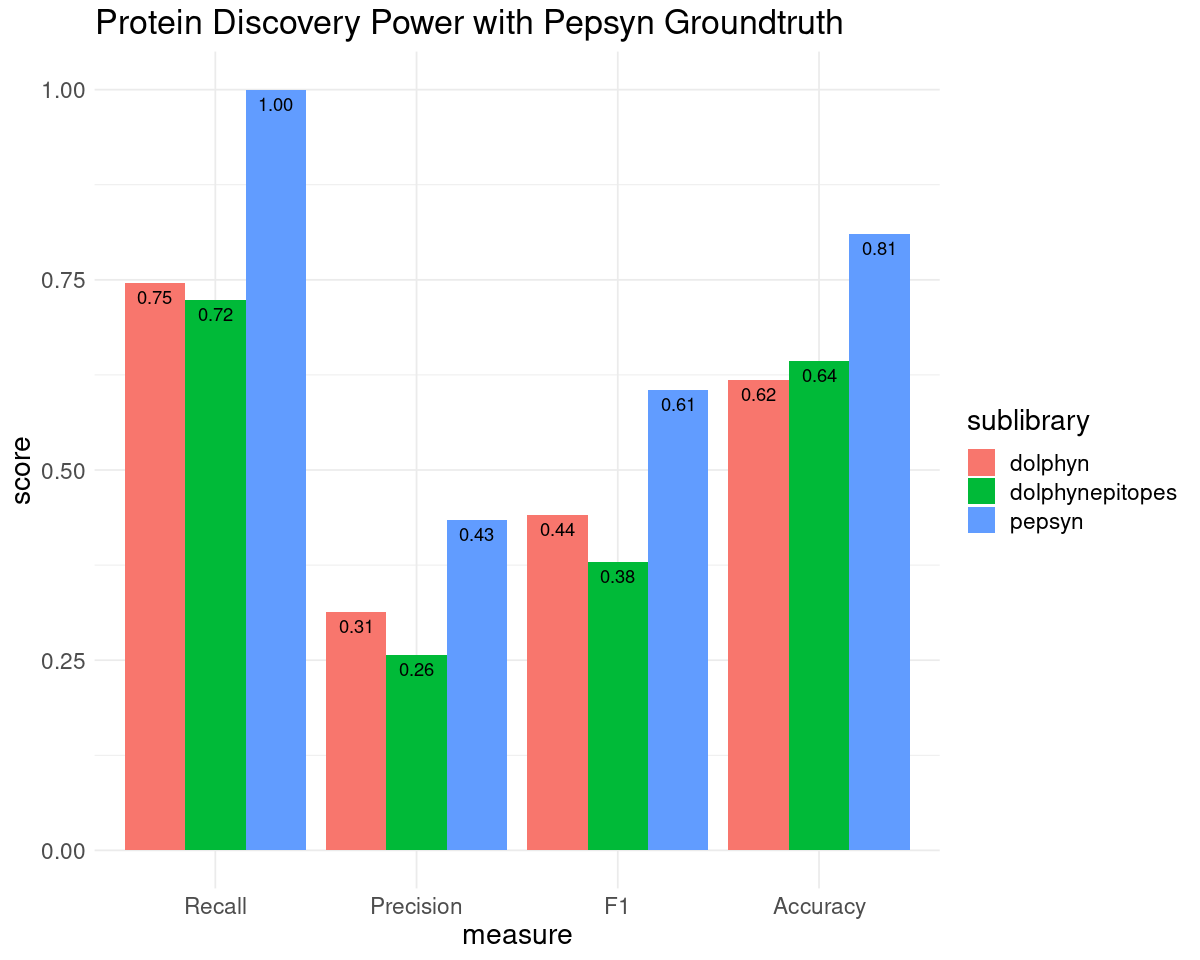

In [9]:
peps %>% subset(sublibrary=="pepsyn") %>% aggregate(reactive ~ pro_id, data = ., FUN = sum) %>% mutate(protein_grountruth = as.numeric(reactive > 1)) %>% select(-reactive) ->> pepsyn_protein_truth
peps %>% aggregate(reactive ~ pro_id + sublibrary, data = ., FUN = max) %>% merge(pepsyn_protein_truth, by = "pro_id") -> protein_df

protein_df %>% subset(protein_grountruth == 1) %>% select(sublibrary, reactive) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ reactive, value.var = "Freq") %>% rename(FN="0",TP="1") %>%
mutate(Recall = TP/(TP+FN)) -> recall_df

protein_df %>% subset(reactive == 1) %>% select(sublibrary, protein_grountruth) %>% 
table() %>% as.data.frame() %>% dcast(sublibrary ~ protein_grountruth, value.var = "Freq") %>% rename(FP="0",TP="1") %>%
mutate(Precision = TP/(TP+FP)) -> prec_df

protein_df %>% subset(reactive == 0) %>% subset(protein_grountruth == 0)  %>% select(sublibrary) %>% 
table() %>% as.data.frame() %>% rename(sublibrary=".",TN="Freq") -> tn_df

merge(recall_df,prec_df) %>% merge(tn_df) %>% 
mutate(F1=2*Precision*Recall/(Precision+Recall)) %>% 
mutate(Accuracy=(TP+TN)/(TP+FN+TN+FP)) -> score_df

score_df %>% select(-TP,-FN,-TN,-FP) %>% 
melt(id.vars = "sublibrary", variable.name="measure", value.name="score") %>%
ggplot(aes(x=measure,y=score,fill = sublibrary)) + geom_bar(position="dodge",stat="identity") + 
geom_text(aes(label=paste0(sprintf("%1.2f", score))), vjust = 1.5, position=position_dodge(.9)) +
ggtitle("Protein Discovery Power with Pepsyn Groundtruth")

# Question
curve, based on pepsyn groundtruth, AA vs reactivity

In [17]:
names(anno_pep)

[1] "tile_id"          "pep_id"           "pro_id"           "pep_rank"        
 [5] "pos_start"        "pos_end"          "UniProt_acc"      "pep_dna"         
 [9] "pep_aa"           "pro_len"          "pro_motifs"       "GO"              
[13] "RefSeq"           "taxon_id"         "taxon_species"    "taxon_genus"     
[17] "gene_symbol"      "gene_synonym"     "product"          "description"     
[21] "Pfam"             "EMBL"             "InterPro"         "pro_id_all"      
[25] "Host_range_taxon" "sublibrary"       "RFproba"          "containsResSite"

In [19]:
anno_pep %>% subset(containsResSite==FALSE) %>% select(tile_id,pro_id,sublibrary,RFproba) %>% rownames_to_column("pepID") -> peps

merge(peps,lhfc %>% rownames_to_column("pepID")) %>% 
melt(id.vars = c("pepID","tile_id","pro_id","sublibrary","RFproba"), value.name = "lhfc", variable.name = "sample") %>% 
mutate(reactive = as.numeric(lhfc >0)) %>%
mutate(samplePro = paste(pro_id,sample)) %>% select(-lhfc) -> sample_protein_bin

In [20]:
# which sample-protein pairs should be reactive according to pepsyn?
sample_protein_bin %>% subset(sublibrary == "pepsyn") %>% 
aggregate(reactive ~ samplePro, data = ., FUN = max) %>% 
subset(reactive > 0) %>% select(-reactive) -> pepsynGT

# which sample-protein pairs should be reactive according to all libraries?
sample_protein_bin %>% aggregate(reactive ~ samplePro, data = ., FUN = max) %>% 
subset(reactive > 0) %>% select(-reactive) -> fairGT

In [21]:
sample_protein_bin %>% aggregate(reactive ~ pepID, data = ., FUN = sum) -> reactive_samples_per_peptide

sample_protein_bin %>% subset(samplePro %in% pepsynGT$samplePro) %>%
aggregate(reactive ~ pepID, data = ., FUN = sum) -> pepsynGT_TP_per_peptide

sample_protein_bin %>% subset(samplePro %in% fairGT$samplePro) %>%
aggregate(reactive ~ pepID, data = ., FUN = sum) -> fairGT_TP_per_peptide

In [23]:
sample_protein_bin -> protein_sample_peptides_with_probas

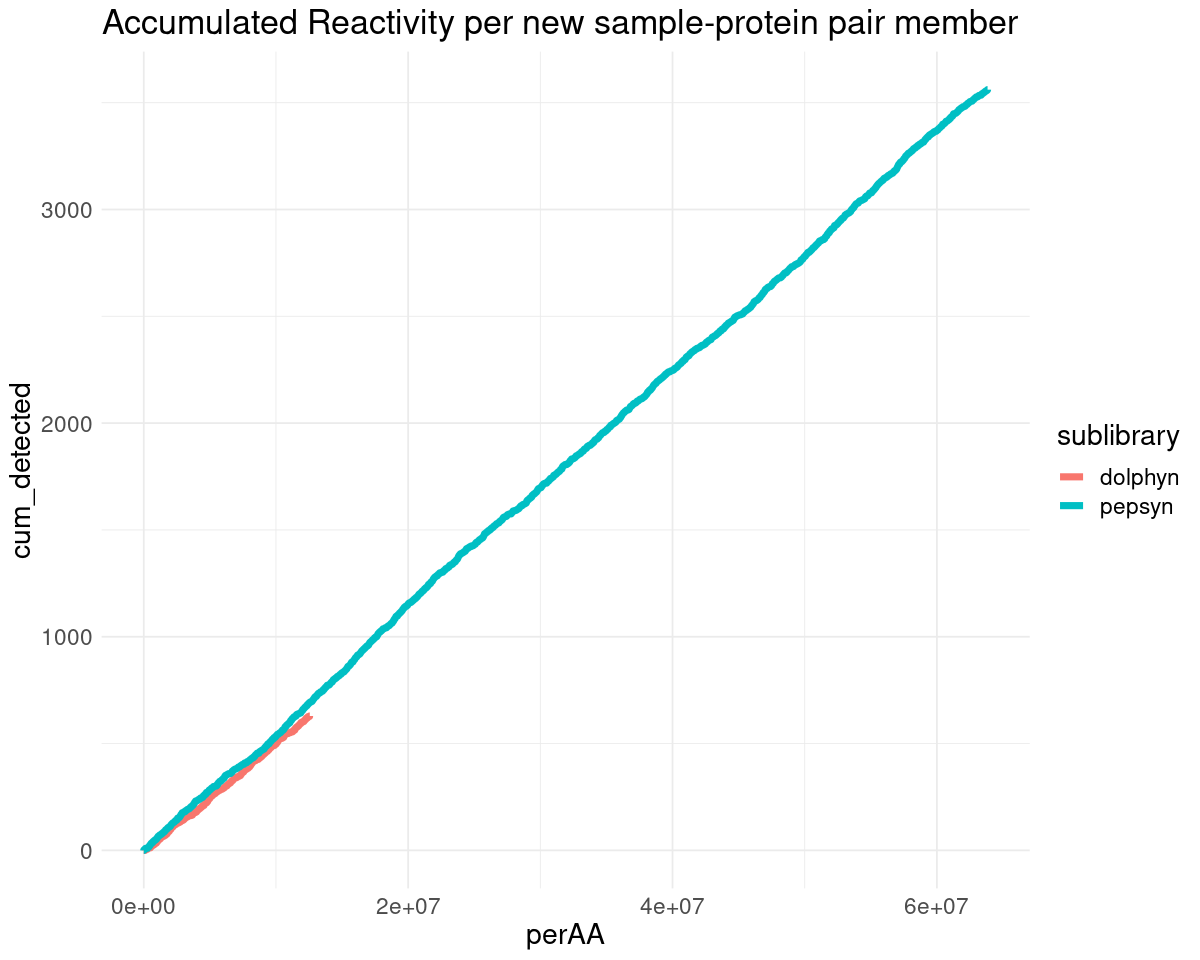

In [27]:
protein_sample_peptides_with_probas %>%
subset(sublibrary != "dolphynepitopes") %>%
mutate(hitGT = ifelse((samplePro %in% pepsynGT$samplePro) & reactive,1,0)) %>% #mark discovered reactivity
sample_frac(1L) %>% arrange(desc(RFproba)) %>%
group_by(sublibrary) %>% mutate(peptides = row_number()) %>%
mutate(cum_detected = cumsum(hitGT)) %>% 
mutate(perAA = case_when(sublibrary=="dolphynepitopes" ~ peptides*15,
                         sublibrary=="dolphyn" ~ peptides*45,
                         sublibrary=="pepsyn" ~ peptides*56)) %>%
#subset(perAA<190000) %>% #zoom
#subset(perAA<2500) %>% #zoom
ggplot(aes(x=perAA, y = cum_detected, color = sublibrary)) + geom_step(size=2) +
ggtitle("Accumulated Reactivity per new sample-protein pair member")

In [31]:
options(repr.plot.width=15, repr.plot.height=8)
set.seed(3)

merge(peps,reactive_samples_per_peptide) %>% # change here for all reactivities, pepsynGT and fairGT: cell above
subset(sublibrary != "dolphynepitopes") %>%
sample_frac(1L) %>% arrange(desc(RFproba)) %>%
group_by(sublibrary) %>% mutate(peptides = row_number()) %>% 
mutate(cum_reactive_samples = cumsum(reactive)) %>% 
mutate(perAA = case_when(sublibrary=="dolphynepitopes" ~ peptides*15,
                         sublibrary=="dolphyn" ~ peptides*45,
                         sublibrary=="pepsyn" ~ peptides*56)) -> temp


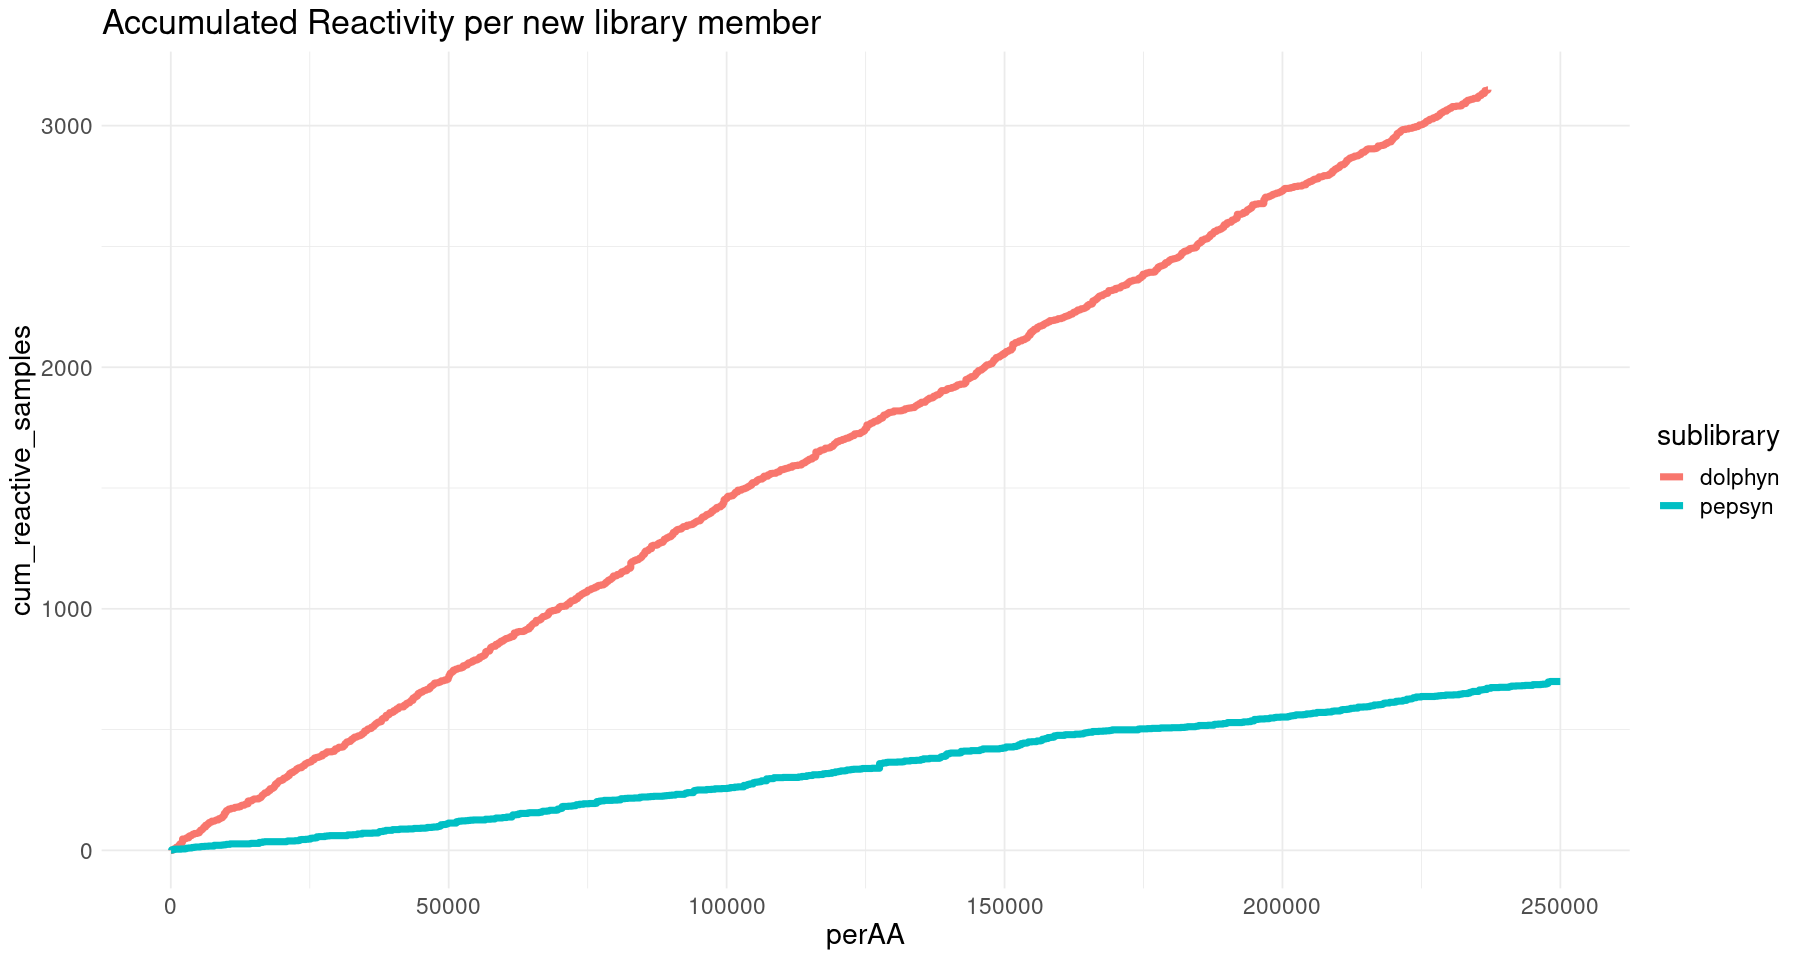

In [32]:
temp %>%
subset(perAA<250000) %>% #zoom
#subset(perAA<2000) %>% #zoom
ggplot(aes(x=perAA, y = cum_reactive_samples, color = sublibrary)) + geom_step(size=2) +
ggtitle("Accumulated Reactivity per new library member")

In [43]:
lhfc[peps$pepID,] -> lhfc

In [49]:
peps %>% select(pepID, sublibrary, RFproba) %>% column_to_rownames("pepID") -> tileProbas2

In [51]:
merge(tileProbas2, lhfc, by='row.names') %>% column_to_rownames("Row.names") %>% 
rownames_to_column("rn") %>% mutate(rn = paste(rn, sublibrary, RFproba)) %>% column_to_rownames("rn") -> df1

In [52]:
df1 %>% arrange(sublibrary, desc(RFproba)) %>% subset(sublibrary == "dolphyn") %>% select(-sublibrary, -RFproba) -> df_d
df1 %>% arrange(sublibrary, desc(RFproba)) %>% subset(sublibrary == "dolphynepitopes") %>% select(-sublibrary, -RFproba) -> df_de
df1 %>% arrange(sublibrary, desc(RFproba)) %>% subset(sublibrary == "pepsyn") %>% select(-sublibrary, -RFproba) -> df_p

In [53]:
df_d %>% mutate_all(function(x){m=which.max(x>0);ifelse(row_number()>=m,1,0)}) %>%
mutate(reactive_individuals = rowSums(.)) %>% mutate(order = row_number()) %>% mutate(library = "Dolphyn") -> df_d1

set.seed(1)
df_p %>% sample_frac(1L) %>% 
mutate_all(function(x){m=which.max(x>0);ifelse(row_number()>=m,1,0)}) %>%
mutate(reactive_individuals = rowSums(.)) %>%
mutate(order = row_number()) %>% mutate(library = "Pepsyn") -> df_p1

df_de %>% mutate_all(function(x){m=which.max(x>0);ifelse(row_number()>=m,1,0)}) %>%
mutate(reactive_individuals = rowSums(.)) %>% mutate(order = row_number()) %>% mutate(library = "Dolphynepitopes") -> df_de1

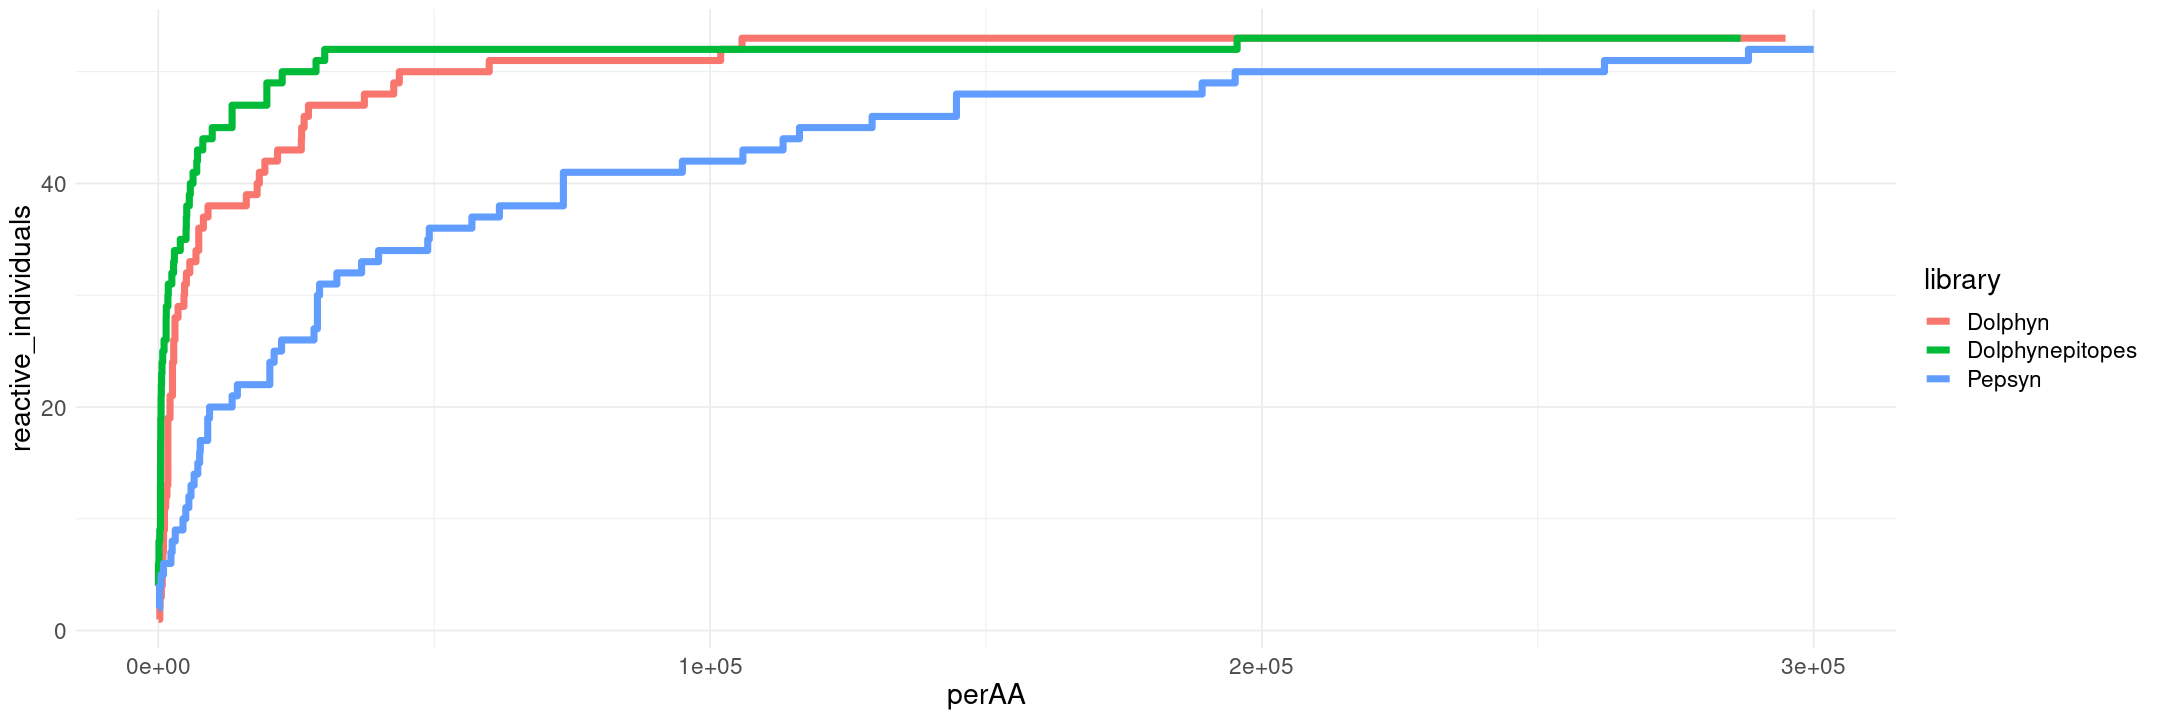

In [55]:
options(repr.plot.width=18, repr.plot.height=6)

rbind(df_d1, df_de1, df_p1) %>% 
#rbind(df_d1, df_p1) %>% 
select("reactive_individuals","order","library") %>% 
mutate(perAA = case_when(library=="Dolphynepitopes" ~ order*15,
                         library=="Dolphyn" ~ order*56, #45
                         library=="Pepsyn" ~ order*56)) %>%
subset(perAA<300000) %>% #zoom
ggplot(aes(x=perAA, y = reactive_individuals, color = library)) + geom_step(size=2)
